In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [3]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *

In [4]:
DATADRIVE = '/datadrive_ssd/'

## Option 1: No log, TIGGE-MRMS

In [22]:
%%time
ds_train1 = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    first_days=5,
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data
CPU times: user 32.9 s, sys: 1.6 s, total: 34.5 s
Wall time: 33.7 s


In [23]:
sampler_train1 = torch.utils.data.WeightedRandomSampler(ds_train1.compute_weights(), len(ds_train1))
dl_train1 = torch.utils.data.DataLoader(ds_train1, batch_size=32, sampler=sampler_train1)

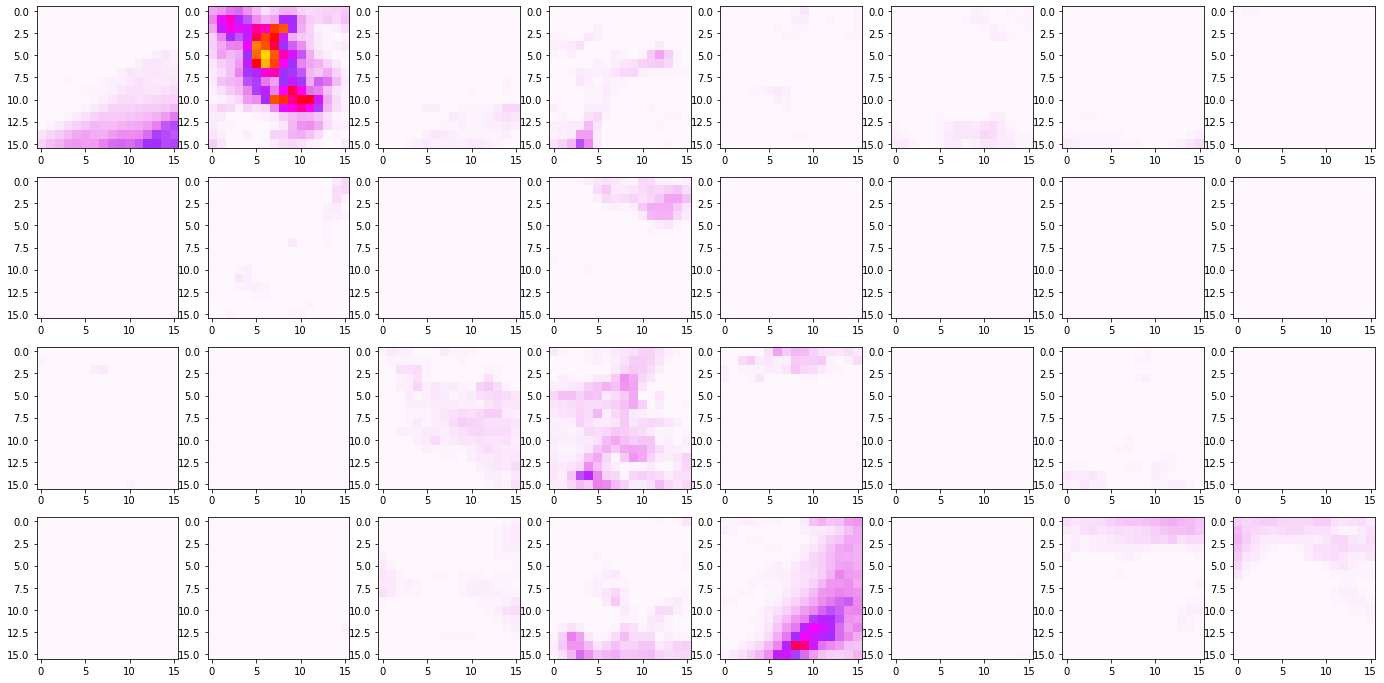

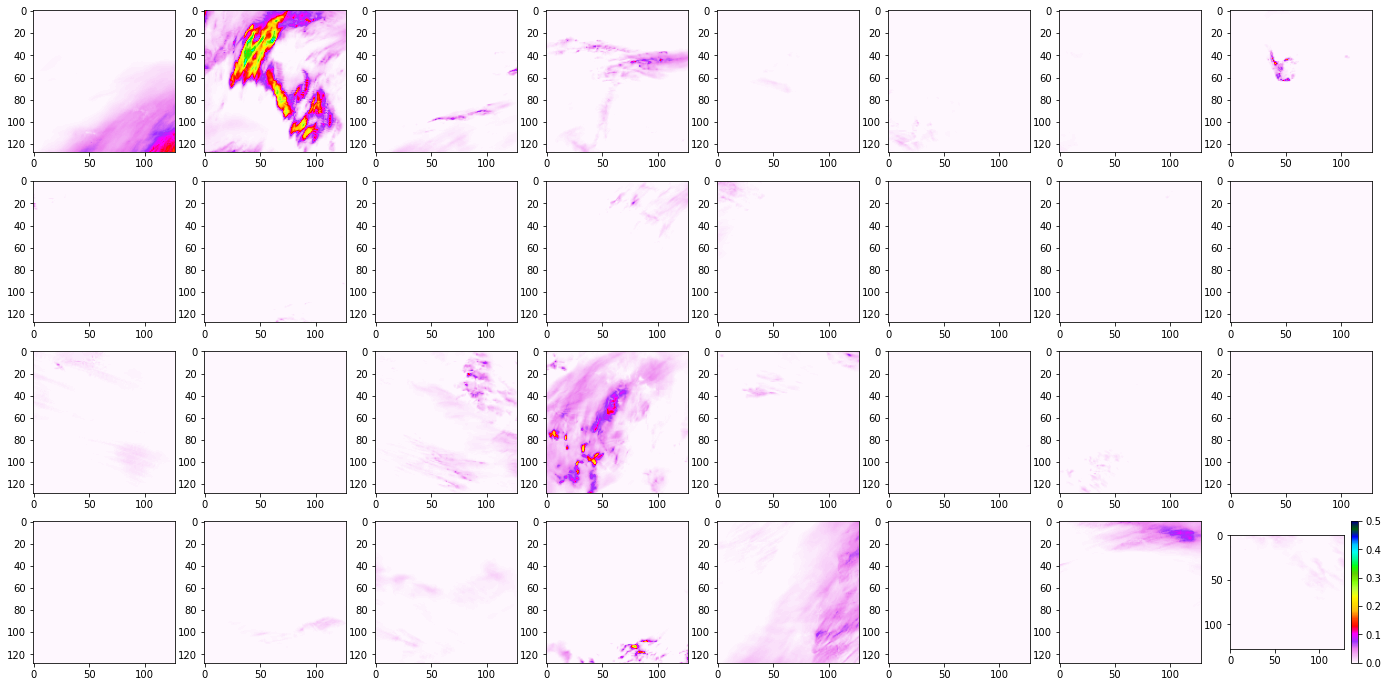

In [65]:
X, Y = next(iter(dl_train1))
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=0.5)
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for y, ax in zip(Y.numpy(), axs.flat):
    I = ax.imshow(y[0], cmap='gist_ncar_r', vmin=0, vmax=0.5)
plt.colorbar(I, ax=axs.flatten()[-1]) 

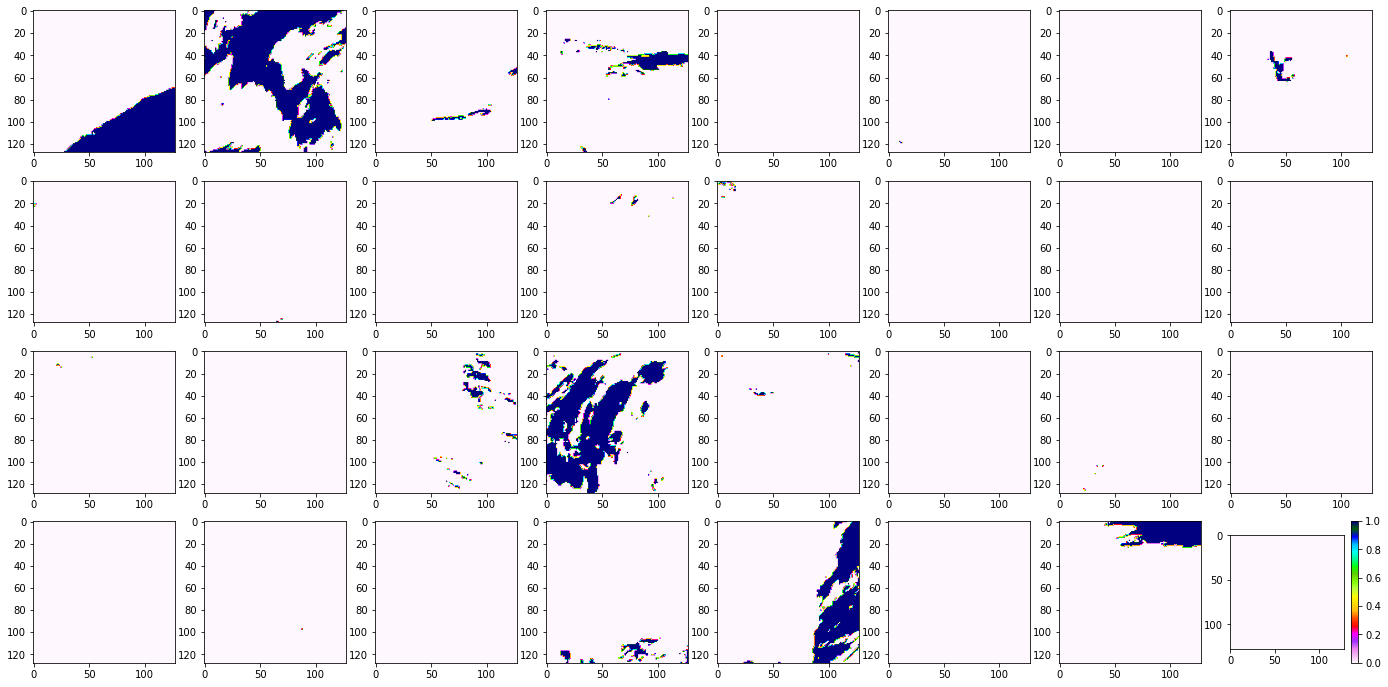

In [67]:
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for y, ax in zip(Y.numpy(), axs.flat):
    y = y > 0.025
    I = ax.imshow(y[0], cmap='gist_ncar_r', vmin=0, vmax=1)
plt.colorbar(I, ax=axs.flatten()[-1]) 

In [47]:
ds_train = ds_train1
dl_train = dl_train1

# Distribution without weighting
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train.__getitem__(idx, no_cat=True)
    mean_precip.append(y.mean())
# Distribution after weighting
mean_precip2 = []
for X, y in dl_train:
    mean_precip2.extend(y.mean((1, 2, 3)).numpy())

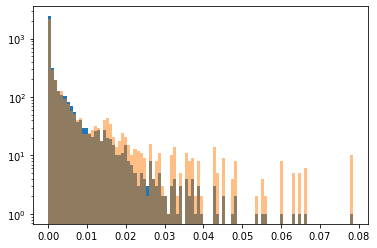

In [54]:
plt.hist(mean_precip, bins=100);
plt.hist(mean_precip2, bins=100, alpha=0.5);
plt.yscale('log')

In [68]:
ds_train = ds_train1
dl_train = dl_train1
threshold = 0.025

# Coverage without weighting
coverage = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train.__getitem__(idx, no_cat=True)
    y = y > threshold
    coverage.append(y.mean())

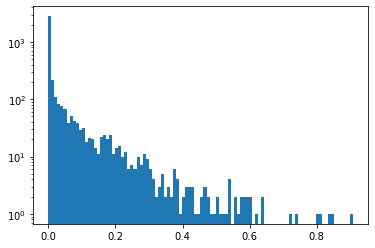

In [70]:
plt.hist(coverage, bins=100);
plt.yscale('log')

In [71]:
bins = [0, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5]

## Option 2: Log TIGGE-MRMS

In [26]:
ds_train2 = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    first_days=5,
    tp_log=1e-1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [27]:
sampler_train2 = torch.utils.data.WeightedRandomSampler(ds_train2.compute_weights(), len(ds_train2))
dl_train2 = torch.utils.data.DataLoader(ds_train2, batch_size=32, sampler=sampler_train2)

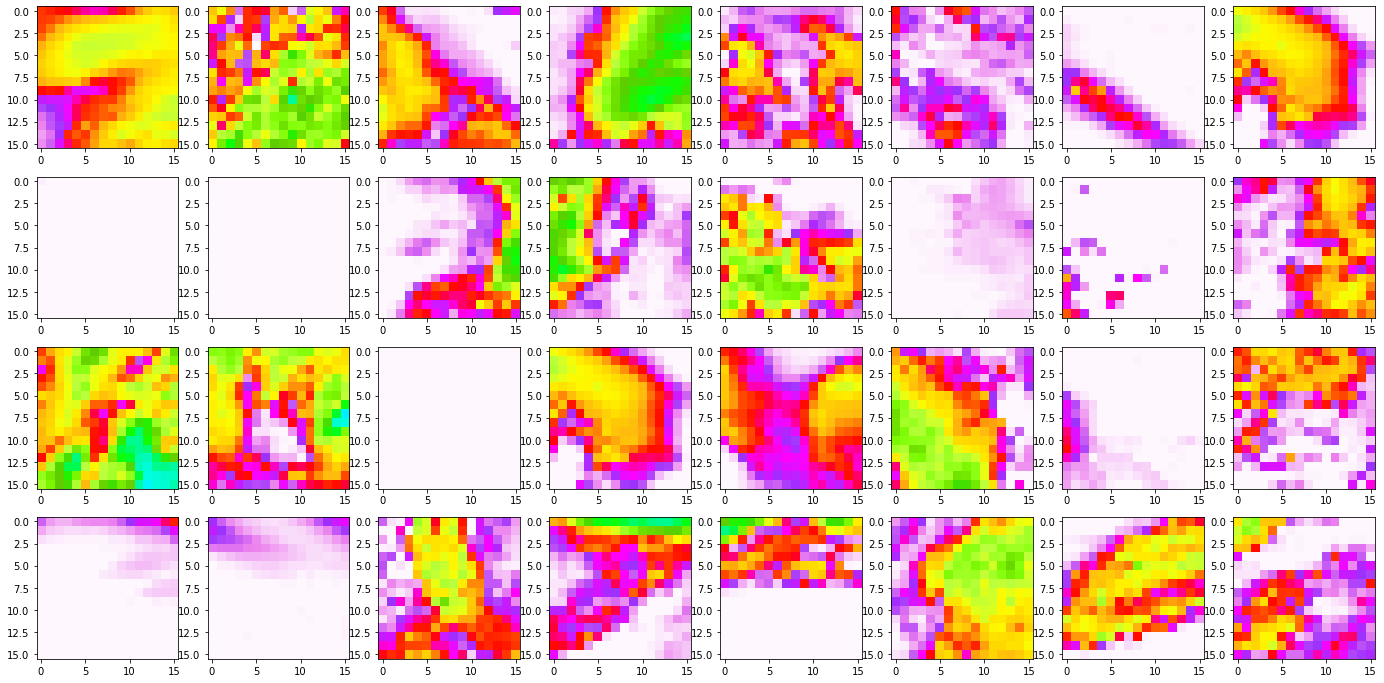

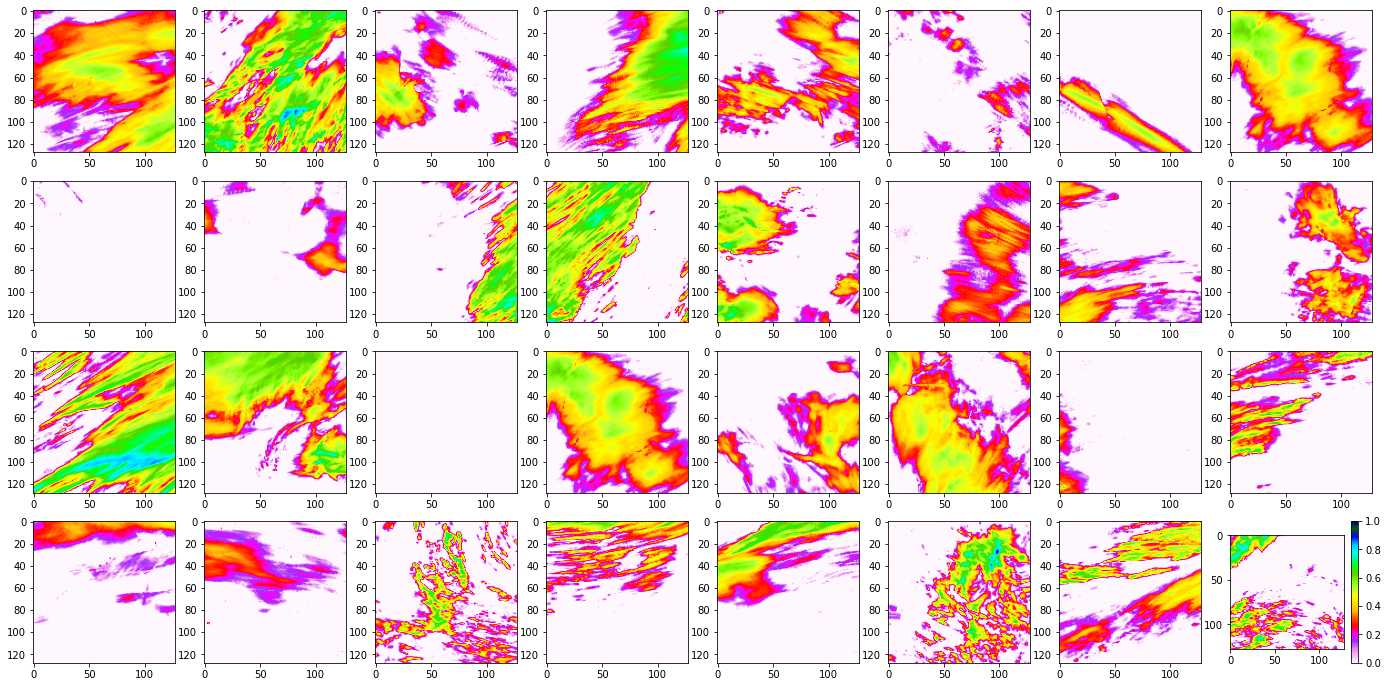

In [60]:
X, Y = next(iter(dl_train2))
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=1)
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for y, ax in zip(Y.numpy(), axs.flat):
    I = ax.imshow(y[0], cmap='gist_ncar_r', vmin=0, vmax=1)
plt.colorbar(I, ax=axs.flatten()[-1])    

In [55]:
ds_train = ds_train2
dl_train = dl_train2

# Distribution without weighting
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train.__getitem__(idx, no_cat=True)
    mean_precip.append(y.mean())
# Distribution after weighting
mean_precip2 = []
for X, y in dl_train:
    mean_precip2.extend(y.mean((1, 2, 3)).numpy())

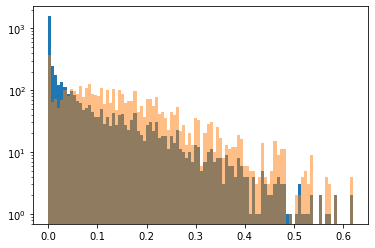

In [62]:
plt.hist(mean_precip, bins=100);
plt.hist(mean_precip2, bins=100, alpha=0.5);
plt.yscale('log')

In [29]:
# Impressions: Barely any zero fields left

## Option 3: Log Pure SR

In [34]:
ds_train3 = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    first_days=5,
    tp_log=1e-1,
    pure_sr_ratio=8
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [35]:
sampler_train3 = torch.utils.data.WeightedRandomSampler(ds_train3.compute_weights(), len(ds_train3))
dl_train3 = torch.utils.data.DataLoader(ds_train3, batch_size=32, sampler=sampler_train3)

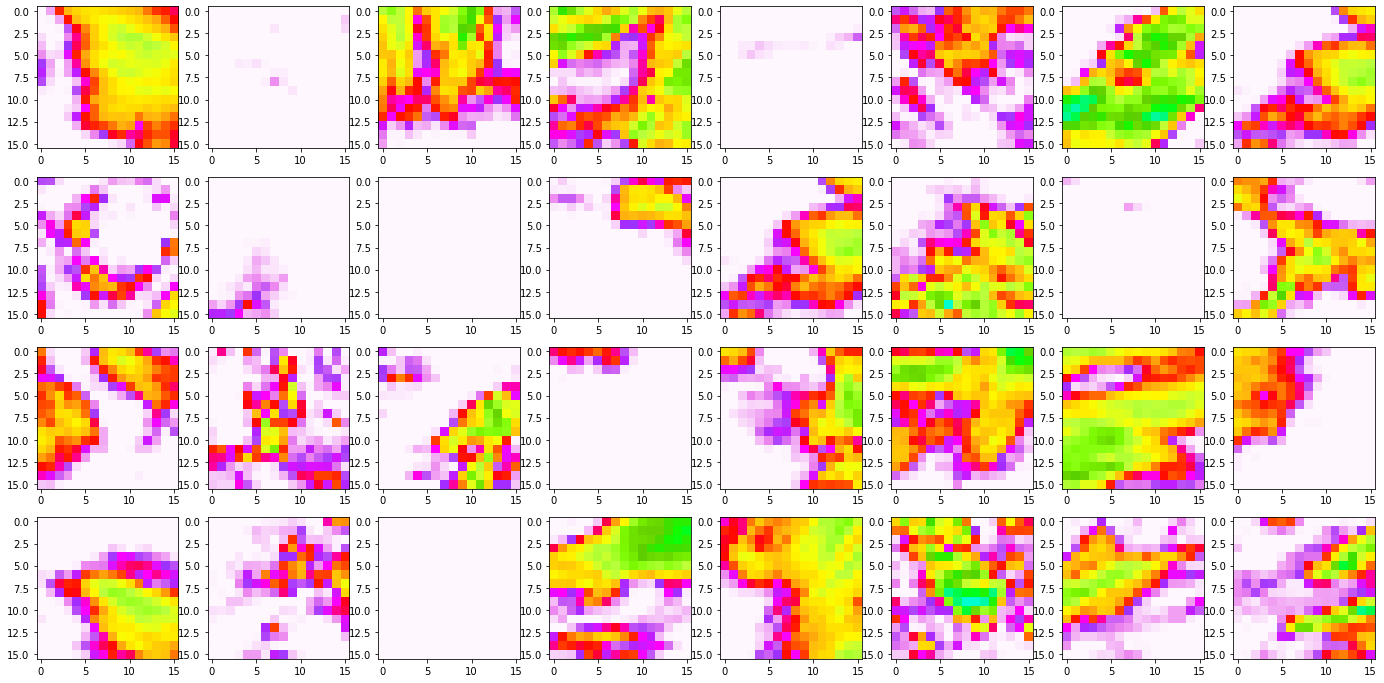

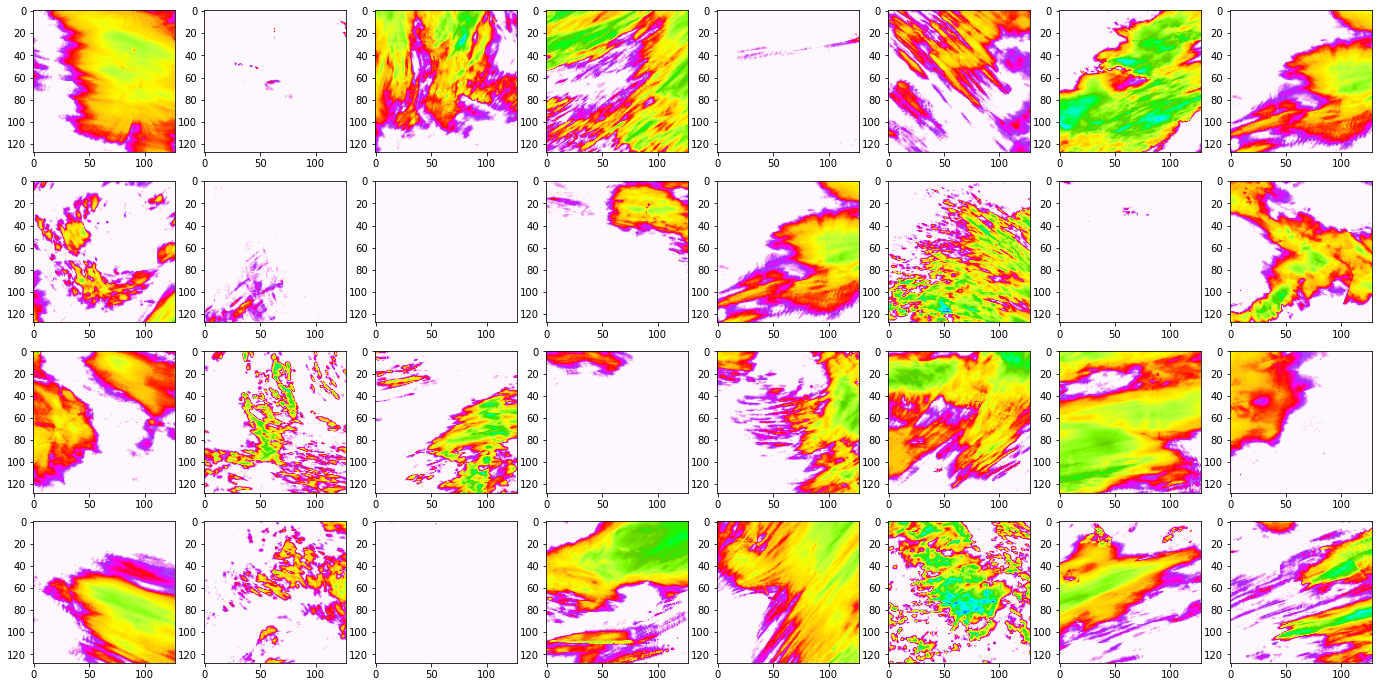

In [63]:
X, Y = next(iter(dl_train3))
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=1)
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for y, ax in zip(Y.numpy(), axs.flat):
    ax.imshow(y[0], cmap='gist_ncar_r', vmin=0, vmax=1)

In [57]:
ds_train = ds_train3
dl_train = dl_train3

# Distribution without weighting
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train.__getitem__(idx, no_cat=True)
    mean_precip.append(y.mean())
# Distribution after weighting
mean_precip2 = []
for X, y in dl_train:
    mean_precip2.extend(y.mean((1, 2, 3)).numpy())

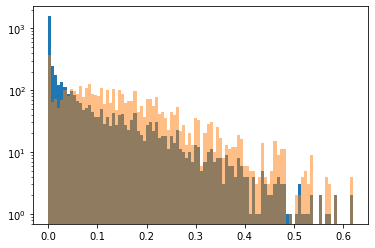

In [58]:
plt.hist(mean_precip, bins=100);
plt.hist(mean_precip2, bins=100, alpha=0.5);
plt.yscale('log')

In [33]:
# Impressions: Lots of zero fields

## Option 4: Coverage bins

In [153]:
%%time
ds_train4 = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
    data_period=('2018-01', '2018-12'),
    first_days=5,
    tp_log=1
)

/anaconda/envs/nwp-downscale/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data
CPU times: user 32.3 s, sys: 1.77 s, total: 34.1 s
Wall time: 33.3 s


In [144]:
sampler_train4 = torch.utils.data.WeightedRandomSampler(ds_train4.compute_weights(), len(ds_train4))
dl_train4 = torch.utils.data.DataLoader(ds_train4, batch_size=32, sampler=sampler_train4)

In [145]:
weights = ds_train4.compute_weights()

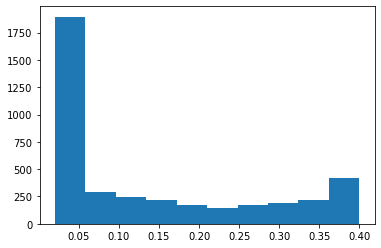

In [146]:
plt.hist(weights);

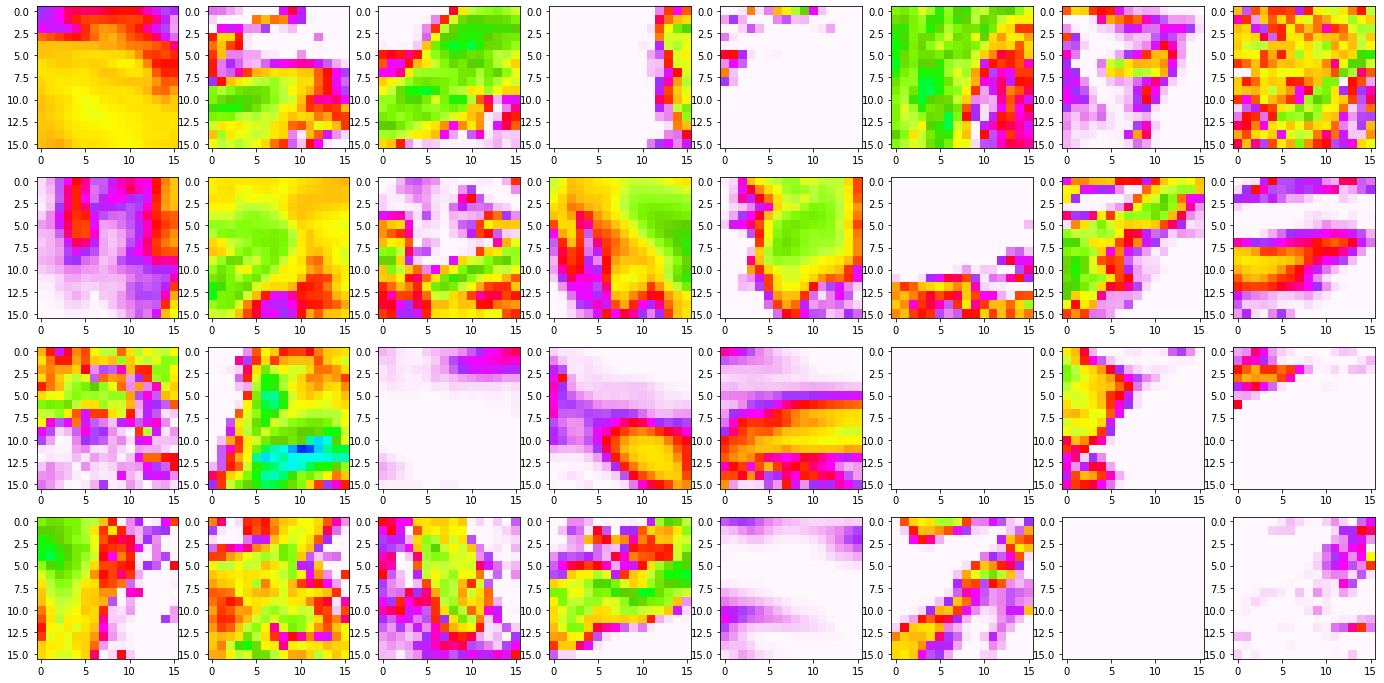

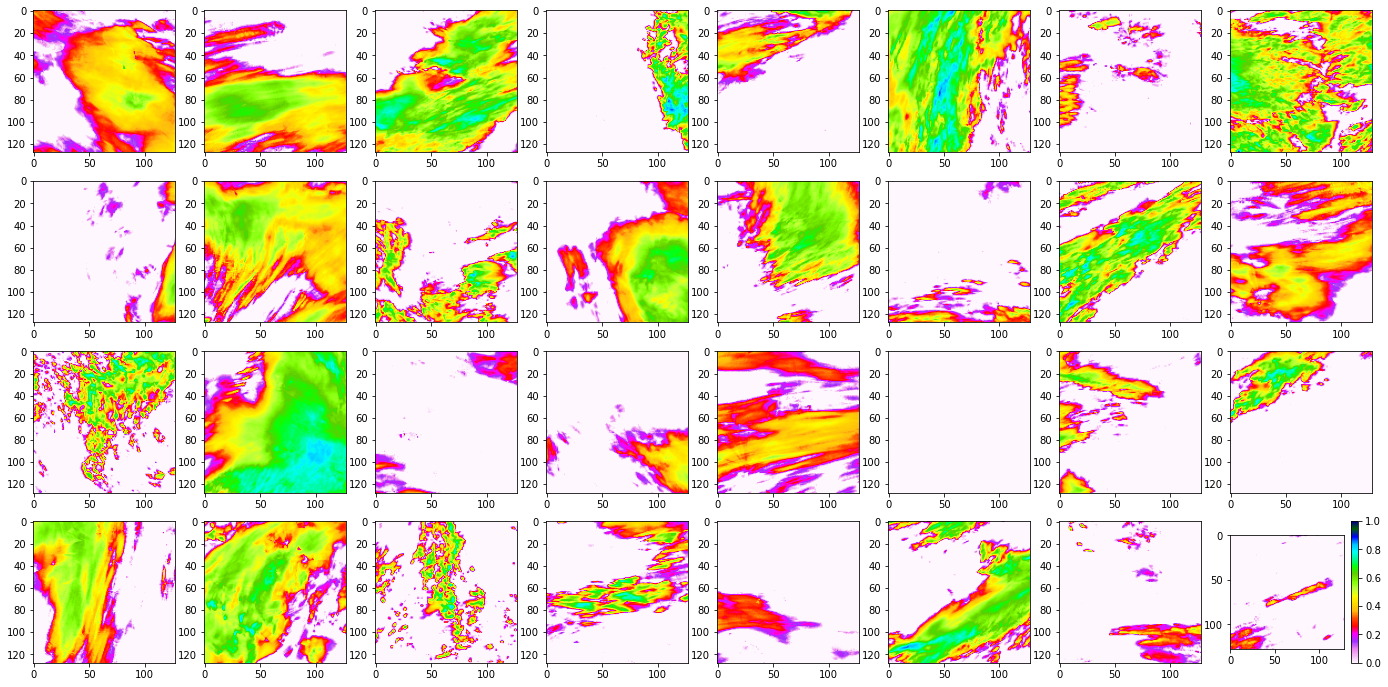

In [150]:
X, Y = next(iter(dl_train4))
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=1)
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for y, ax in zip(Y.numpy(), axs.flat):
    I = ax.imshow(y[0], cmap='gist_ncar_r', vmin=0, vmax=1)
plt.colorbar(I, ax=axs.flatten()[-1]) 

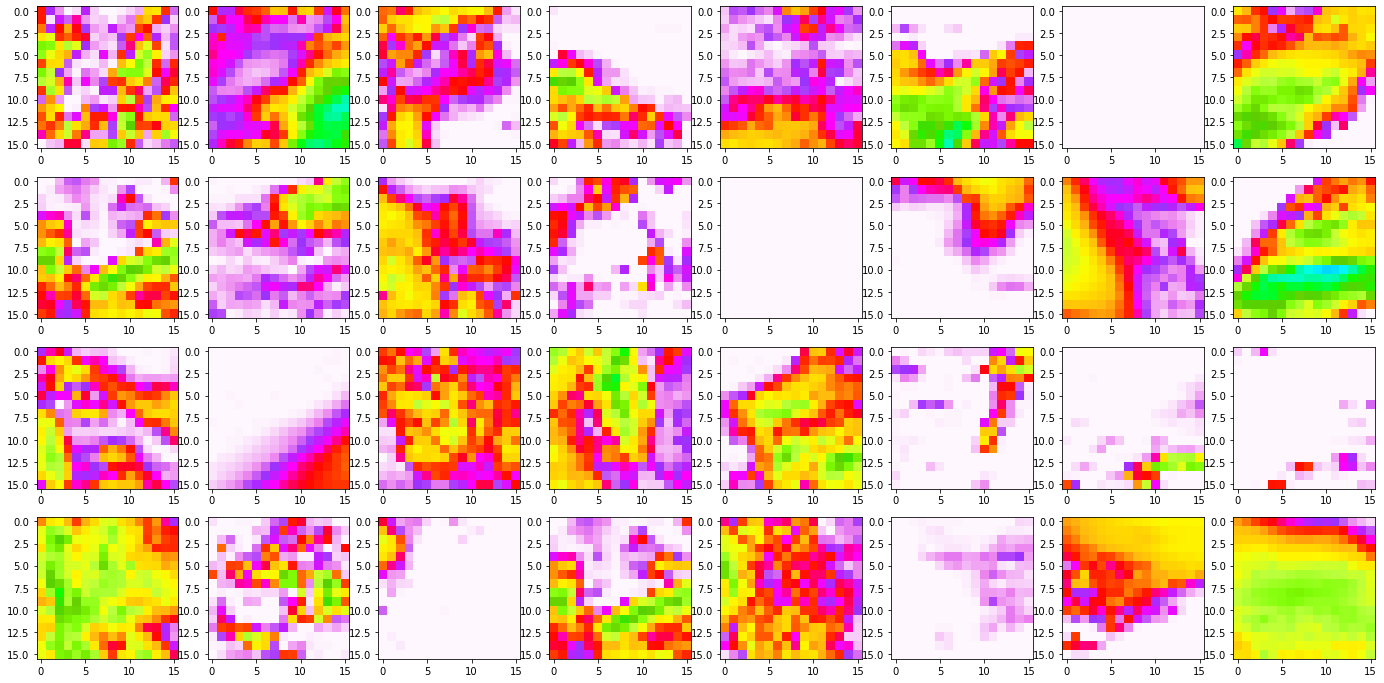

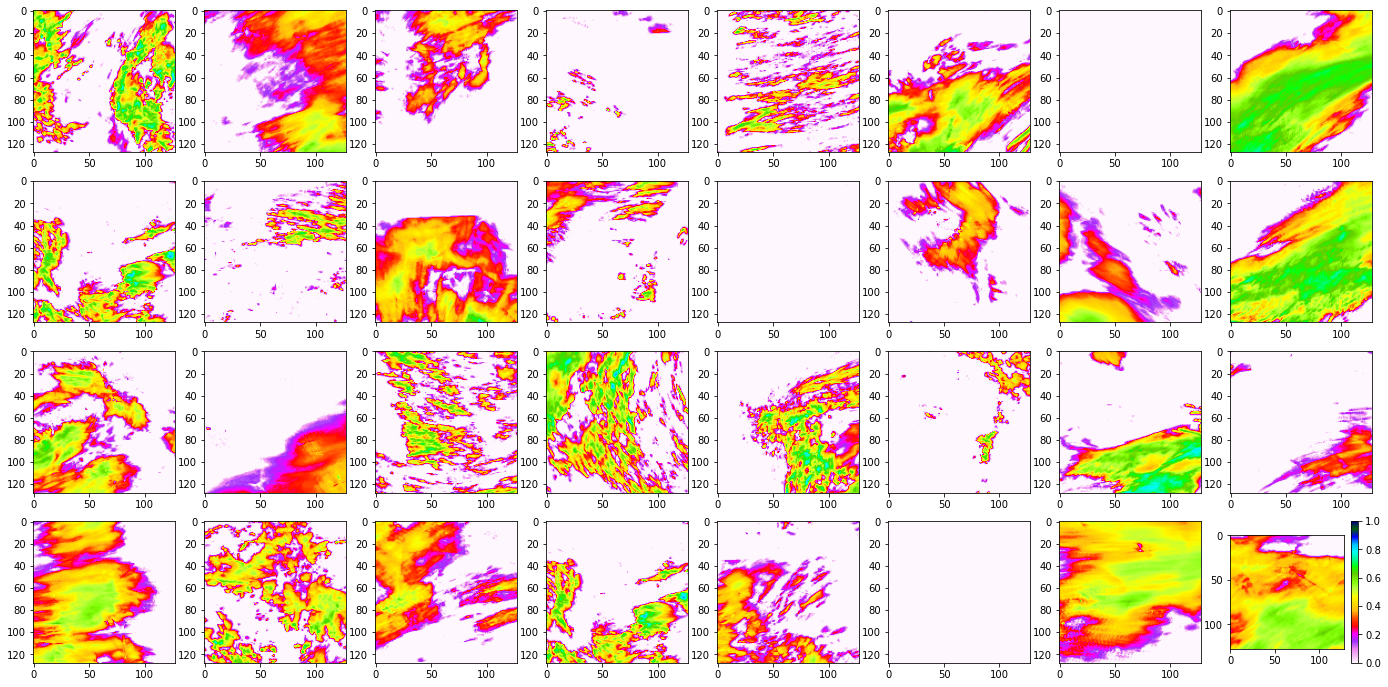

In [155]:
ds_train4.pure_sr_ratio = 8
X, Y = next(iter(dl_train4))
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for x, ax in zip(X.numpy(), axs.flat):
    ax.imshow(x[0], cmap='gist_ncar_r', vmin=0, vmax=1)
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for y, ax in zip(Y.numpy(), axs.flat):
    I = ax.imshow(y[0], cmap='gist_ncar_r', vmin=0, vmax=1)
plt.colorbar(I, ax=axs.flatten()[-1]) 

In [148]:
ds_train = ds_train4
dl_train = dl_train4

# Distribution without weighting
mean_precip = []
for idx in range(len(ds_train.idxs)):
    X, y = ds_train.__getitem__(idx, no_cat=True)
    mean_precip.append(y.mean())
# Distribution after weighting
mean_precip2 = []
for X, y in dl_train:
    mean_precip2.extend(y.mean((1, 2, 3)).numpy())

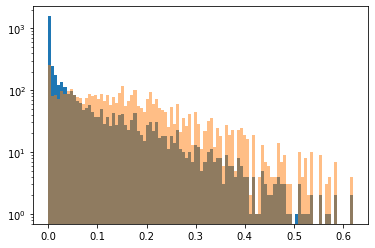

In [149]:
plt.hist(mean_precip, bins=100);
plt.hist(mean_precip2, bins=100, alpha=0.5);
plt.yscale('log')

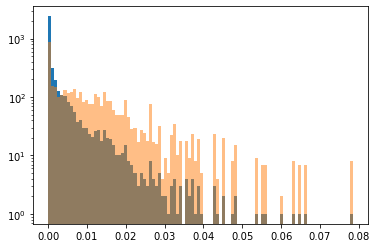

In [142]:
plt.hist(mean_precip, bins=100);
plt.hist(mean_precip2, bins=100, alpha=0.5);
plt.yscale('log')

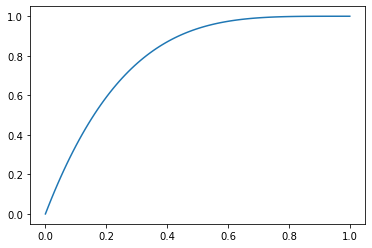

In [136]:
x = np.linspace(0, 1, 100)
y = 1-(x-1)**4
plt.plot(x, y)

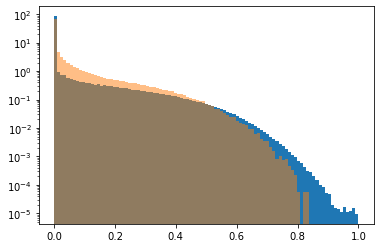

In [154]:
plt.hist(ds_train4.mrms.values.flatten(), bins=np.linspace(0, 1, 100), density=True);
plt.hist(ds_train4.tigge.values.flatten(), bins=np.linspace(0, 1, 100), density=True, alpha=0.5);
plt.yscale('log')

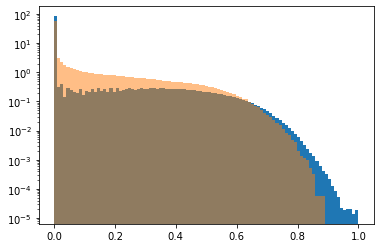

In [51]:
plt.hist(ds_train_log.mrms.values.flatten(), bins=np.linspace(0, 1, 100), density=True);
plt.hist(ds_train_log.tigge.values.flatten(), bins=np.linspace(0, 1, 100), density=True, alpha=0.5);
plt.yscale('log')
# plt.ylim(0, 2)

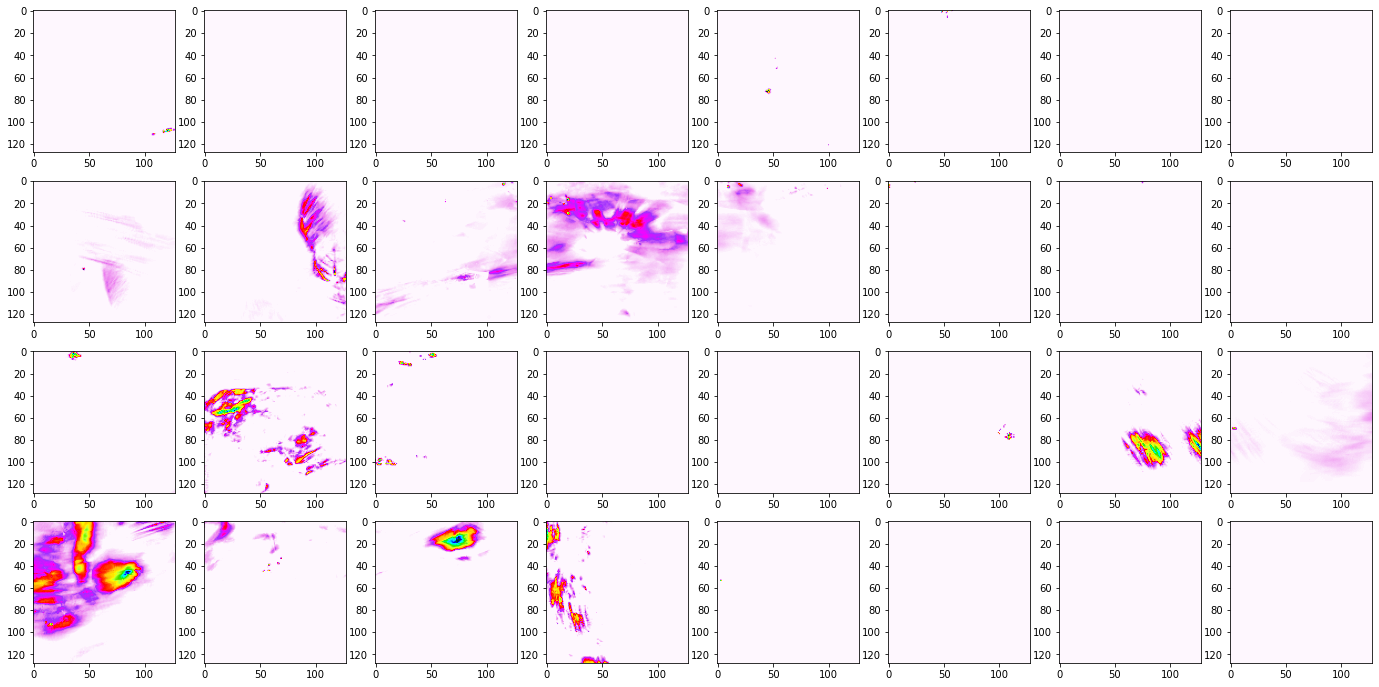

In [32]:
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for i, ax in enumerate(axs.flat):
    X, y = ds_train[i+62]
    ax.imshow(y[0], cmap='gist_ncar_r')

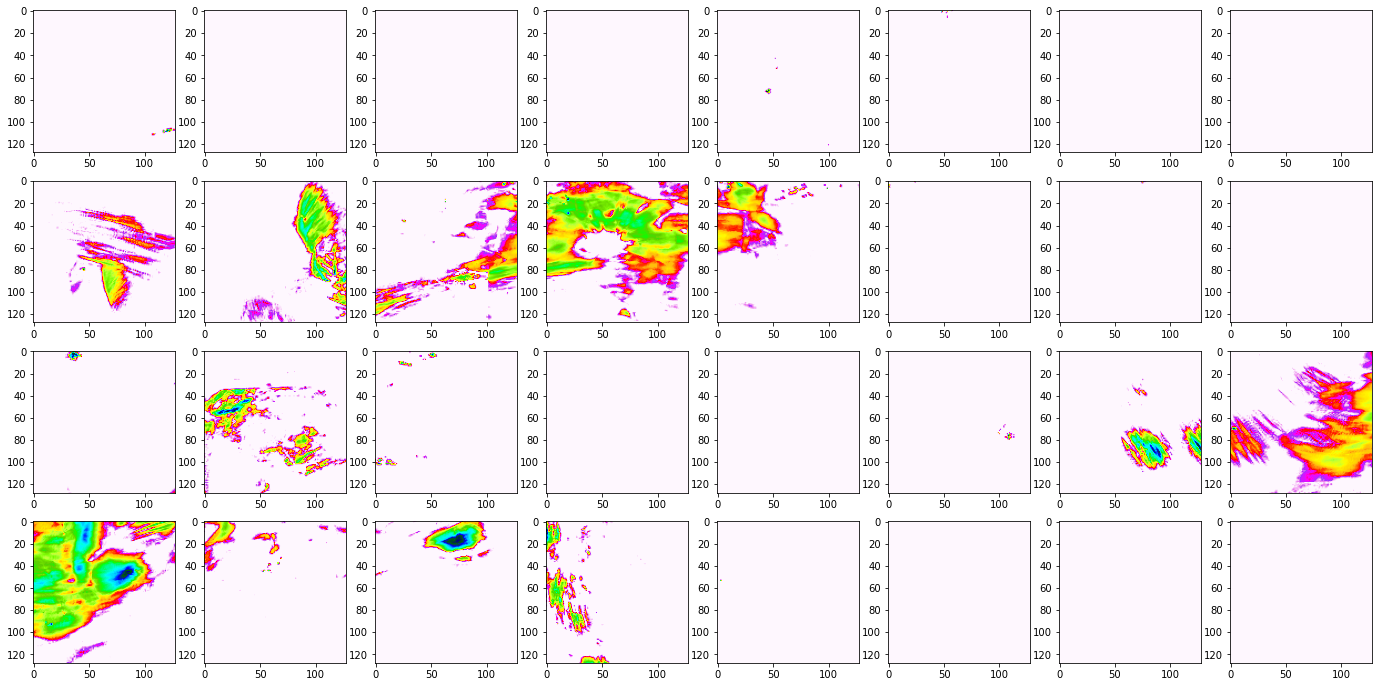

In [50]:
fig, axs = plt.subplots(4, 8, figsize=(24, 12))
for i, ax in enumerate(axs.flat):
    X, y = ds_train_log[i+62]
    ax.imshow(y[0], cmap='gist_ncar_r')